# Point detection on ROSpace

## Import Dataset

In [1]:
import os
import pandas as pd
import pickle
import random
from datetime import datetime
import pandas as pd 
import gc
import numpy as np 

In [2]:
root = './data/cic_iot_23'
dataset = '/dataset/train_test'
train_csv = root + dataset + '/train_set.csv'
test_csv = root + dataset + '/test_set.csv'
labels_p = root + '/dataset/labels'
model = root + '/models/xgb/'
preds_p = model + 'preds'
results_p = model + 'results'
sequences_train = root + dataset + '/sequence_indexes_train.pkl'
sequences_test = root + dataset + '/sequence_indexes_test.pkl'

In [ ]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

/tmp/ipykernel_2620303/1651161990.py:1: DtypeWarning: Columns (11,12,13,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_csv)


In [ ]:
print(train_df.shape), print(test_df.shape)

In [ ]:
train_df.rename(columns={'layers.frame.frame.time': 'timestamp'}, inplace=True)
test_df.rename(columns={'layers.frame.frame.time': 'timestamp'}, inplace=True)

## Prepare the data for ML
In this section, we prepare the data to be processed by ML algorithms. In particular, we perform the following steps:

### Convert Label columns to Numeric values
We substitute label values with numeric binary values.

In [ ]:
#np.save(labels_p + '/multi_err_label_train', train_df['label'].to_numpy())
np.save(labels_p + '/multi_label_test.csv', test_df['label'].to_numpy())

In [ ]:
print(train_df['label'].value_counts()), print(test_df['label'].value_counts())

In [ ]:
multi_err_label_train = train_df['label']

train_df['label'] = train_df['label'].replace('syn', 1) 
train_df['label'] = train_df['label'].replace('portscan', 2)
train_df['label'] = train_df['label'].replace('icmp_dos', 3) 
train_df['label'] = train_df['label'].replace('normal', 0)

train_df['label'] = pd.to_numeric(train_df['label'])

train_df['label'].unique(), train_df['label'].nunique()

In [ ]:
multi_err_label_test = test_df['label']

test_df['label'] = test_df['label'].replace('syn', 1) 
test_df['label'] = test_df['label'].replace('portscan', 2)
test_df['label'] = test_df['label'].replace('icmp_dos', 3) 
test_df['label'] = test_df['label'].replace('normal', 0)

test_df['label'] = pd.to_numeric(test_df['label'])

test_df['label'].unique(), test_df['label'].nunique()

In [ ]:
train_df['label'] = train_df['label'].replace(2, 1)
train_df['label'] = train_df['label'].replace(3, 1) 

In [ ]:
test_df['label'] = test_df['label'].replace(2, 1)
test_df['label'] = test_df['label'].replace(3, 1) 

In [ ]:
print(train_df['label'].value_counts()), print(test_df['label'].value_counts())

In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'],
               format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'],
               format='%Y-%m-%d %H:%M:%S.%f')

In [92]:
np.save(labels_p + '/test_timestamp', test_df['timestamp'])

In [93]:
timestamps = train_df['timestamp'].values

windows = {
    '1s': pd.Timedelta('1s'),
    '10s': pd.Timedelta('10s'),
    '5min': pd.Timedelta('0.5s'),
    '30min': pd.Timedelta('0.1s')
}

for label, delta in windows.items():
    counts = []
    for i in range(len(timestamps)):
        start_time = timestamps[i] - np.timedelta64(delta)
        start_idx = np.searchsorted(timestamps, start_time, side='left')
        counts.append(i - start_idx)
    train_df[f'count_{label}'] = counts

In [94]:
timestamps = test_df['timestamp'].values

windows = {
    '1s': pd.Timedelta('1s'),
    '10s': pd.Timedelta('10s'),
    '5min': pd.Timedelta('0.5s'),
    '30min': pd.Timedelta('0.1s')
}

for label, delta in windows.items():
    counts = []
    for i in range(len(timestamps)):
        start_time = timestamps[i] - np.timedelta64(delta)
        start_idx = np.searchsorted(timestamps, start_time, side='left')
        counts.append(i - start_idx)
    test_df[f'count_{label}'] = counts

In [95]:
train_timestamp = train_df['timestamp'].to_numpy()
test_timestamp = test_df['timestamp'].to_numpy()

In [96]:
for col in train_df.columns:
    try:
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    except Exception:
        pass  # Skip columns that can't be

In [97]:
for col in test_df.columns:
    try:
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    except Exception:
        pass  # Skip columns that can't be

In [98]:
for col in train_df.columns:
    print(f"{col}: {train_df[col].dtype}")

timestamp: int64
layers.frame.frame.number: int64
layers.frame.frame.len: int64
layers.frame.frame.protocols: float64
layers.eth.eth.dst: float64
layers.eth.eth.dst_tree.eth.dst_resolved: float64
layers.eth.eth.dst_tree.eth.dst.oui: int64
layers.eth.eth.dst_tree.eth.dst.oui_resolved: float64
layers.eth.eth.dst_tree.eth.addr: float64
layers.eth.eth.dst_tree.eth.addr_resolved: float64
layers.eth.eth.dst_tree.eth.addr.oui: int64
layers.eth.eth.dst_tree.eth.addr.oui_resolved: float64
layers.eth.eth.dst_tree.eth.dst.lg: float64
layers.eth.eth.dst_tree.eth.dst.ig: float64
layers.eth.eth.src: float64
layers.eth.eth.src_tree.eth.src_resolved: float64
layers.eth.eth.src_tree.eth.src.oui: float64
layers.eth.eth.src_tree.eth.addr.oui: int64
layers.eth.eth.src_tree.eth.addr.oui_resolved: float64
layers.eth.eth.src_tree.eth.src.lg: float64
layers.eth.eth.src_tree.eth.src.ig: float64
layers.eth.eth.src_tree.eth.ig: float64
layers.eth.eth.type: float64
layers.ip.ip.version: float64
layers.ip.ip.hdr_l

In [99]:
no_cat_cols = test_df.select_dtypes(exclude=['object', 'number']).columns
print(no_cat_cols)

Index([], dtype='object')


In [100]:
cat_cols = train_df.select_dtypes(exclude=['number']).columns
print(cat_cols)

Index([], dtype='object')


In [101]:
cat_cols = test_df.select_dtypes(exclude=['number']).columns
print(cat_cols)

Index([], dtype='object')


### Convert String to Numeric

In [102]:
#list_column_string=train_df.select_dtypes(exclude=[np.number])

for i in cat_cols:
    if i != 'timestamp':
        train_df[i] = pd.Categorical(train_df[i])

In [103]:
#list_column_string=test_df.select_dtypes(exclude=[np.number])

for i in cat_cols:
    if i != 'timestamp':
        test_df[i] = pd.Categorical(test_df[i])

In [104]:
for i in cat_cols:
    if i != 'timestamp':
        train_df[i] = train_df[i].cat.codes

In [105]:
for i in cat_cols:
    if i != 'timestamp':
        test_df[i] = test_df[i].cat.codes

## Handle Inf and NaN

In [106]:
nan_check = train_df.isna()

In [107]:
nan_check

,timestamp,layers.frame.frame.number,layers.frame.frame.len,layers.frame.frame.protocols,layers.eth.eth.dst,layers.eth.eth.dst_tree.eth.dst_resolved,layers.eth.eth.dst_tree.eth.dst.oui,layers.eth.eth.dst_tree.eth.dst.oui_resolved,layers.eth.eth.dst_tree.eth.addr,layers.eth.eth.dst_tree.eth.addr_resolved,...,layers.tcp.tcp.pdu.size,layers.mqtt.mqtt.hdrflags,layers.mqtt.mqtt.hdrflags_tree.mqtt.msgtype,layers.mqtt.mqtt.len,label,sequence,count_1s,count_10s,count_5min,count_30min
0,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,True,False,False,False,False
1,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,True,False,False,False,False
2,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,True,False,False,False,False
3,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,True,False,False,False,False
4,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8871587,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,False,False,False,False,False
8871588,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,False,False,False,False,False
8871589,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,False,False,False,False,False
8871590,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,False,False,False,False,False,False


In [108]:
inf_check = np.isinf(train_df)

In [109]:
inf_check

,timestamp,layers.frame.frame.number,layers.frame.frame.len,layers.frame.frame.protocols,layers.eth.eth.dst,layers.eth.eth.dst_tree.eth.dst_resolved,layers.eth.eth.dst_tree.eth.dst.oui,layers.eth.eth.dst_tree.eth.dst.oui_resolved,layers.eth.eth.dst_tree.eth.addr,layers.eth.eth.dst_tree.eth.addr_resolved,...,layers.tcp.tcp.pdu.size,layers.mqtt.mqtt.hdrflags,layers.mqtt.mqtt.hdrflags_tree.mqtt.msgtype,layers.mqtt.mqtt.len,label,sequence,count_1s,count_10s,count_5min,count_30min
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8871587,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8871588,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8871589,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8871590,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [110]:
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

## Load attack sequences for evaluation

In [111]:
with open(sequences_train, 'rb') as f:
    train_seq = pickle.load(f)

In [112]:
with open(sequences_test, 'rb') as f:
    test_seq = pickle.load(f)

## Drop Hidden Labels

In [113]:
train_df = train_df.drop('sequence', axis=1)
test_df = test_df.drop('sequence', axis=1)

## Convert Pandas Dataframe to Numpy 

In [114]:
train_y = train_df['label'].to_numpy()
train_df = train_df.drop('label', axis=1)

In [115]:
test_y = test_df['label'].to_numpy()

In [116]:
np.save(labels_p + '/test_y', test_y)

In [117]:
test_df = test_df.drop('label', axis=1)

In [118]:
train_df['timestamp'] = pd.Categorical(train_df['timestamp'])
train_df['timestamp'] = train_df['timestamp'].cat.codes
test_df['timestamp'] = pd.Categorical(test_df['timestamp'])
test_df['timestamp'] = test_df['timestamp'].cat.codes

In [119]:
train_x = train_df.to_numpy()
test_x = test_df.to_numpy()

In [120]:
print(train_x.shape)
print(test_x.shape)

(8871592, 204)
(8773656, 204)


In [121]:
train_df.shape, test_df.shape

((8871592, 204), (8773656, 204))

In [122]:
multi_err_label_test = multi_err_label_test.to_numpy()
multi_err_label_train = multi_err_label_train.to_numpy()

In [123]:
test_y[test_seq[49]]

array([1, 1, 1, ..., 1, 1, 1], shape=(42147,))

In [124]:
print(train_df.dtypes.value_counts())

float64    194
int64        9
int32        1
Name: count, dtype: int64


## XGBoost

### Train XGBoost 

In [542]:
from xgboost import XGBClassifier

In [543]:
scale = 0.998

In [544]:
bst = XGBClassifier(scale_pos_weight=scale, n_estimators=1200,  objective='binary:logistic')

In [545]:
bst.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1200,
              n_jobs=None, num_parallel_tree=None, ...)

In [546]:
#bst.save_model('./data/models/dos_mqtt_iot/xgb/xgb_dos_mqtt_iot.h5')

In [547]:
#bst.load_model('./data/models/dos_mqtt_iot/xgb/xgb_dos_mqtt_iot.h5')

### Test XGBoost 

In [548]:
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np 

In [549]:
preds = bst.predict(test_x)

In [550]:
preds_proba = bst.predict_proba(test_x)

In [551]:
np.save(preds_p + '/preds', preds)
np.save(preds_p + '/preds_proba', preds_proba)

In [552]:
#preds_proba = np.load('./data/models/dos_mqtt_iot/xgb/preds_proba.npy')
#preds = np.load('./data/models/dos_mqtt_iot/xgb/preds.npy')

In [553]:
feature_importance = bst.feature_importances_
feature_importance = list(zip(test_df.columns, bst.feature_importances_))

# Sort the list by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

In [554]:
feature_importance

[('count_30min', np.float32(0.68379337)),
 ('layers.eth.eth.dst_tree.eth.addr_resolved', np.float32(0.03174618)),
 ('layers.frame.frame.len', np.float32(0.03134246)),
 ('layers.eth.eth.src_tree.eth.src.oui', np.float32(0.030715618)),
 ('layers.ip.ip.flags_tree.ip.flags.rb', np.float32(0.024320006)),
 ('count_5min', np.float32(0.018870786)),
 ('layers.tcp.tcp.stream', np.float32(0.018224306)),
 ('layers.eth.eth.src', np.float32(0.01476302)),
 ('layers.ip.ip.id', np.float32(0.01025184)),
 ('layers.ip.ip.flags_tree.ip.flags.mf', np.float32(0.009060266)),
 ('layers.tcp.tcp.len', np.float32(0.008968495)),
 ('layers.tcp.tcp.options_tree.tcp.options.wscale_tree.tcp.options.wscale.shift',
  np.float32(0.008336965)),
 ('layers.tcp.tcp.dstport', np.float32(0.007513136)),
 ('layers.ip.ip.dsfield', np.float32(0.0071821553)),
 ('layers.llc.llc.ssap_tree.llc.ssap.sap', np.float32(0.006587629)),
 ('layers.tcp.tcp.port', np.float32(0.0050733387)),
 ('layers.ip.ip.ttl', np.float32(0.0046140137)),
 ('la

### Evaluate Overall data point classification performances

In [555]:
import sklearn
from sklearn import metrics

In [556]:
acc=sklearn.metrics.accuracy_score(test_y, preds)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(test_y, preds).ravel()
print("usual accuracy and confusion matrix tn, fp, fn, tp")
acc, tn, fp, fn, tp

usual accuracy and confusion matrix tn, fp, fn, tp


(0.8818601960231858,
 np.int64(2638037),
 np.int64(181206),
 np.int64(855312),
 np.int64(5099101))

In [557]:
fposr = fp / (tp + fp)
print(fposr)

0.03431732283747896


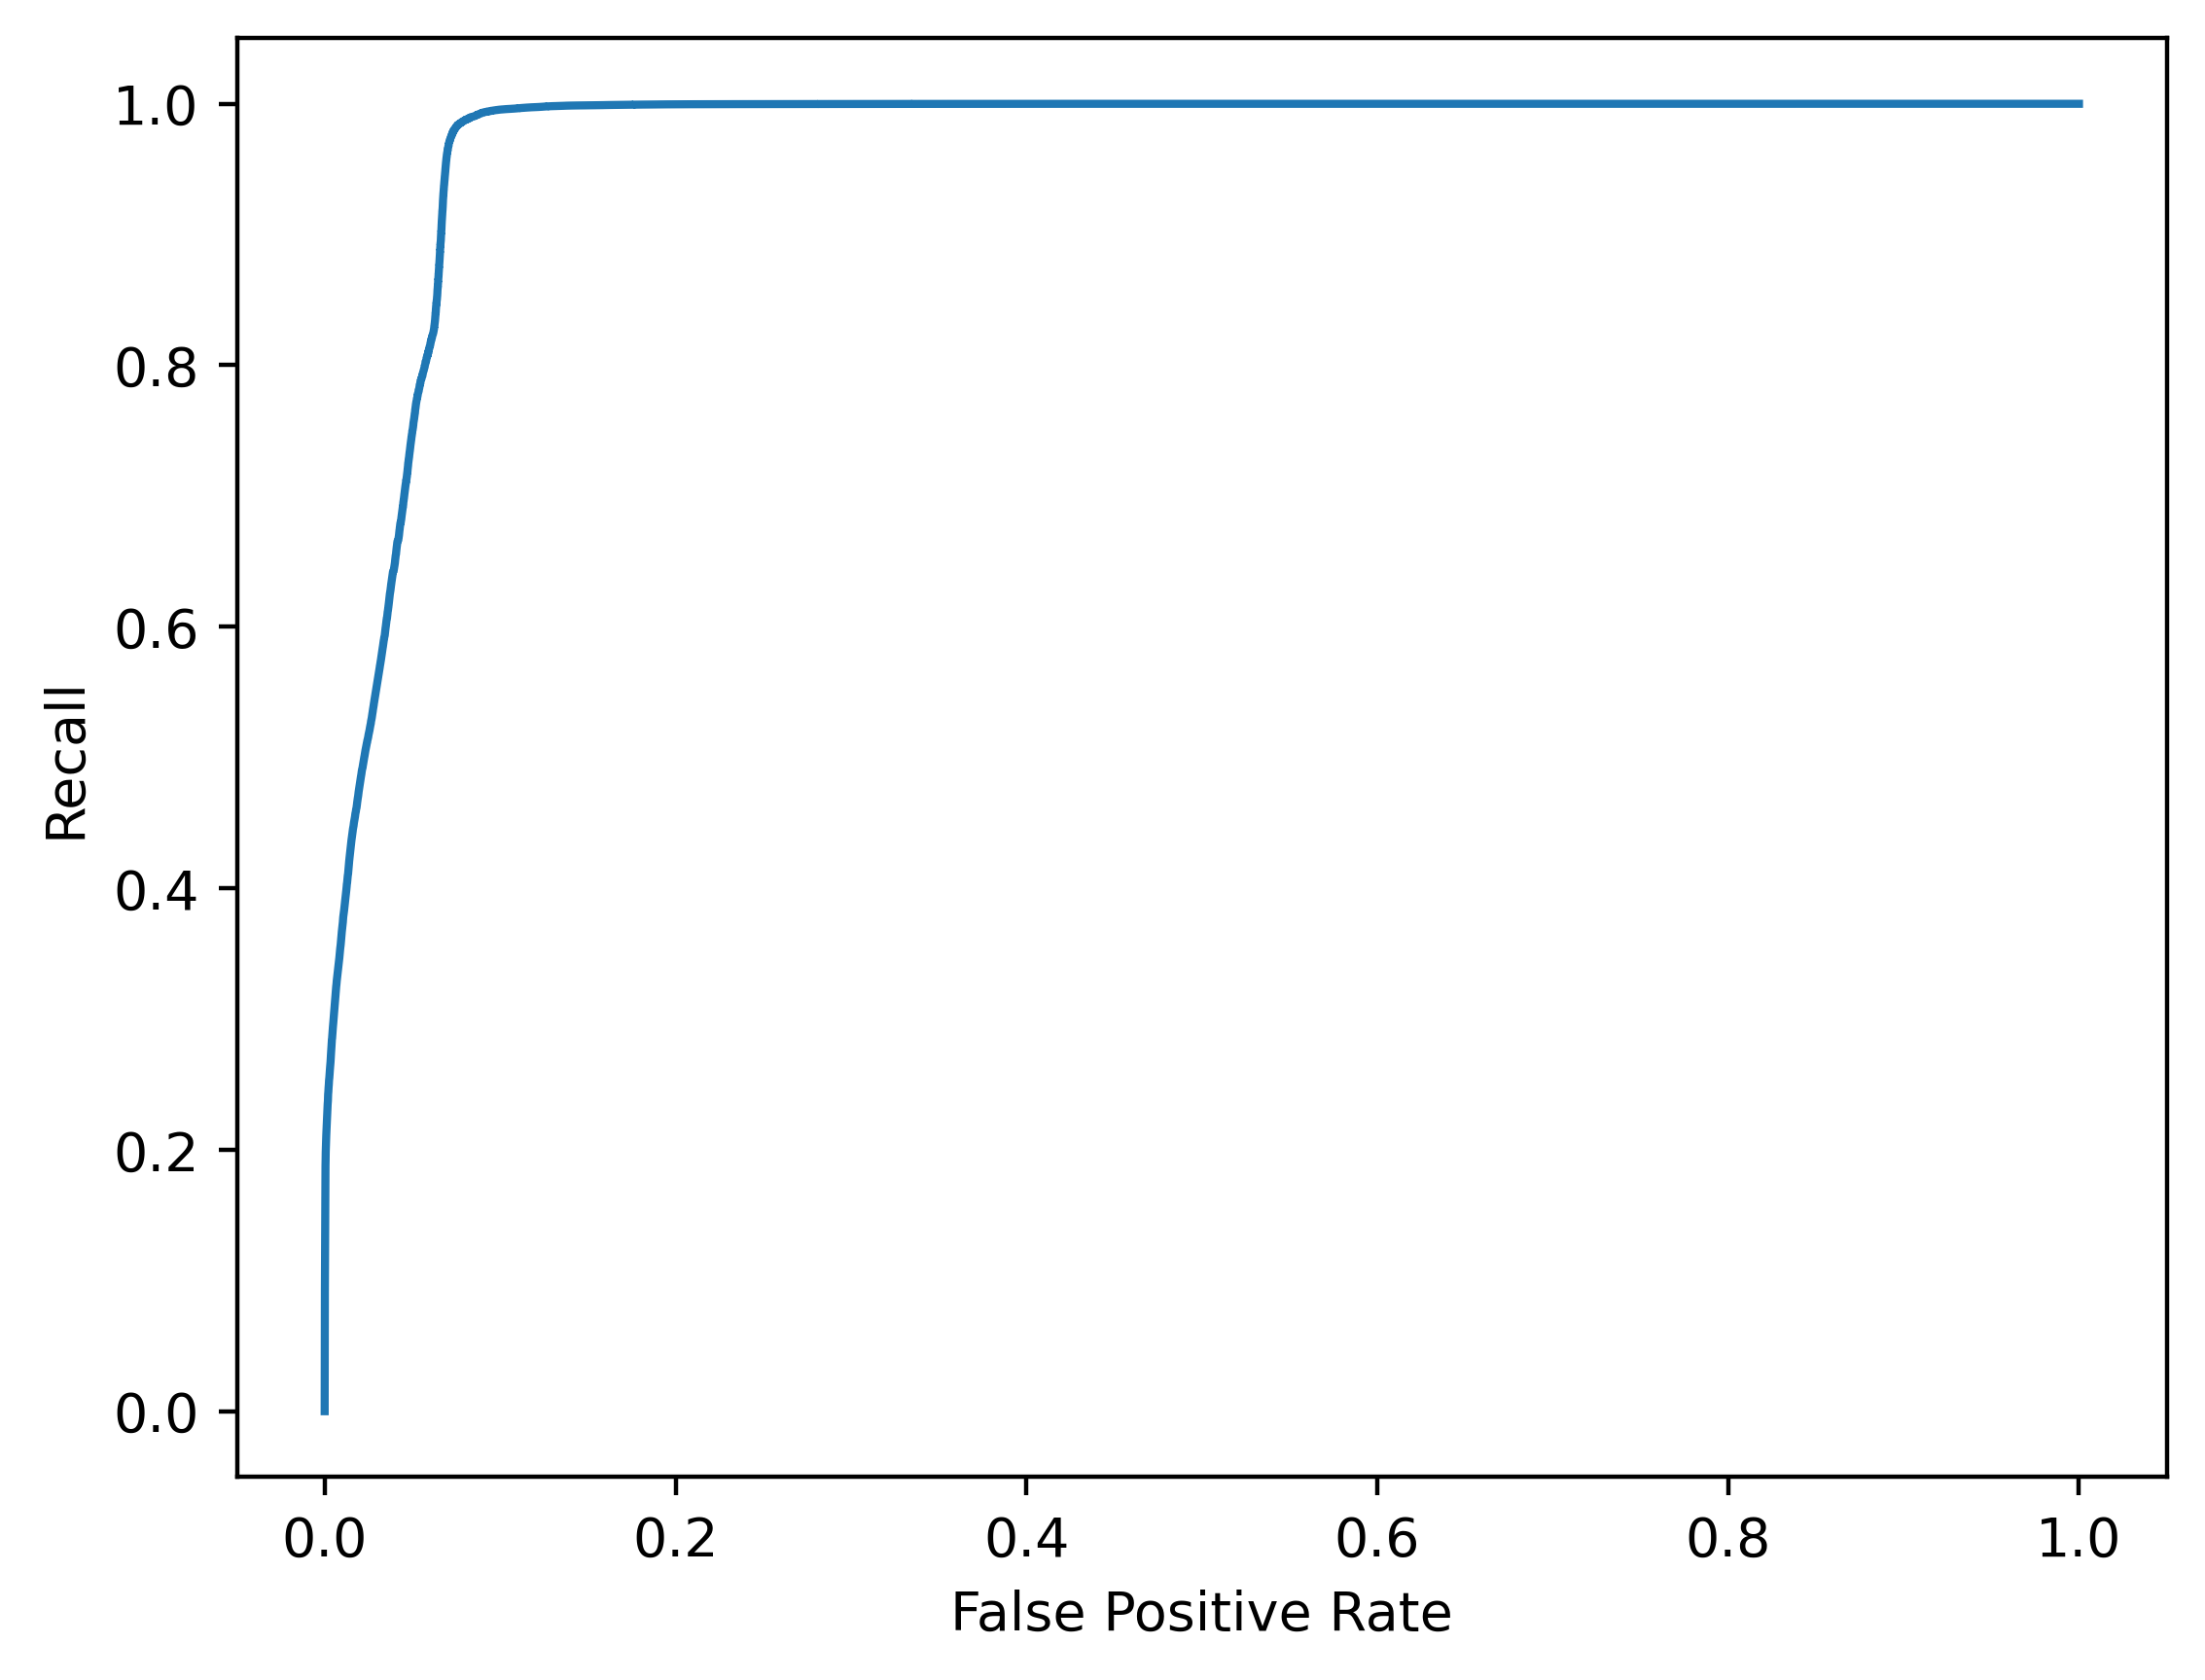

In [558]:
plt.figure(dpi=400)
fpr, tpr, _ = metrics.roc_curve(test_y,  preds_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel('Recall')
plt.xlabel('False Positive Rate')
plt.show()

In [559]:
pr = sklearn.metrics.precision_score(test_y, preds)
rec = sklearn.metrics.recall_score(test_y, preds)
print(pr, rec)

0.9656826771625211 0.8563566215511084


In [560]:
precision, recall, thr = metrics.precision_recall_curve(test_y,  preds_proba[:,1])

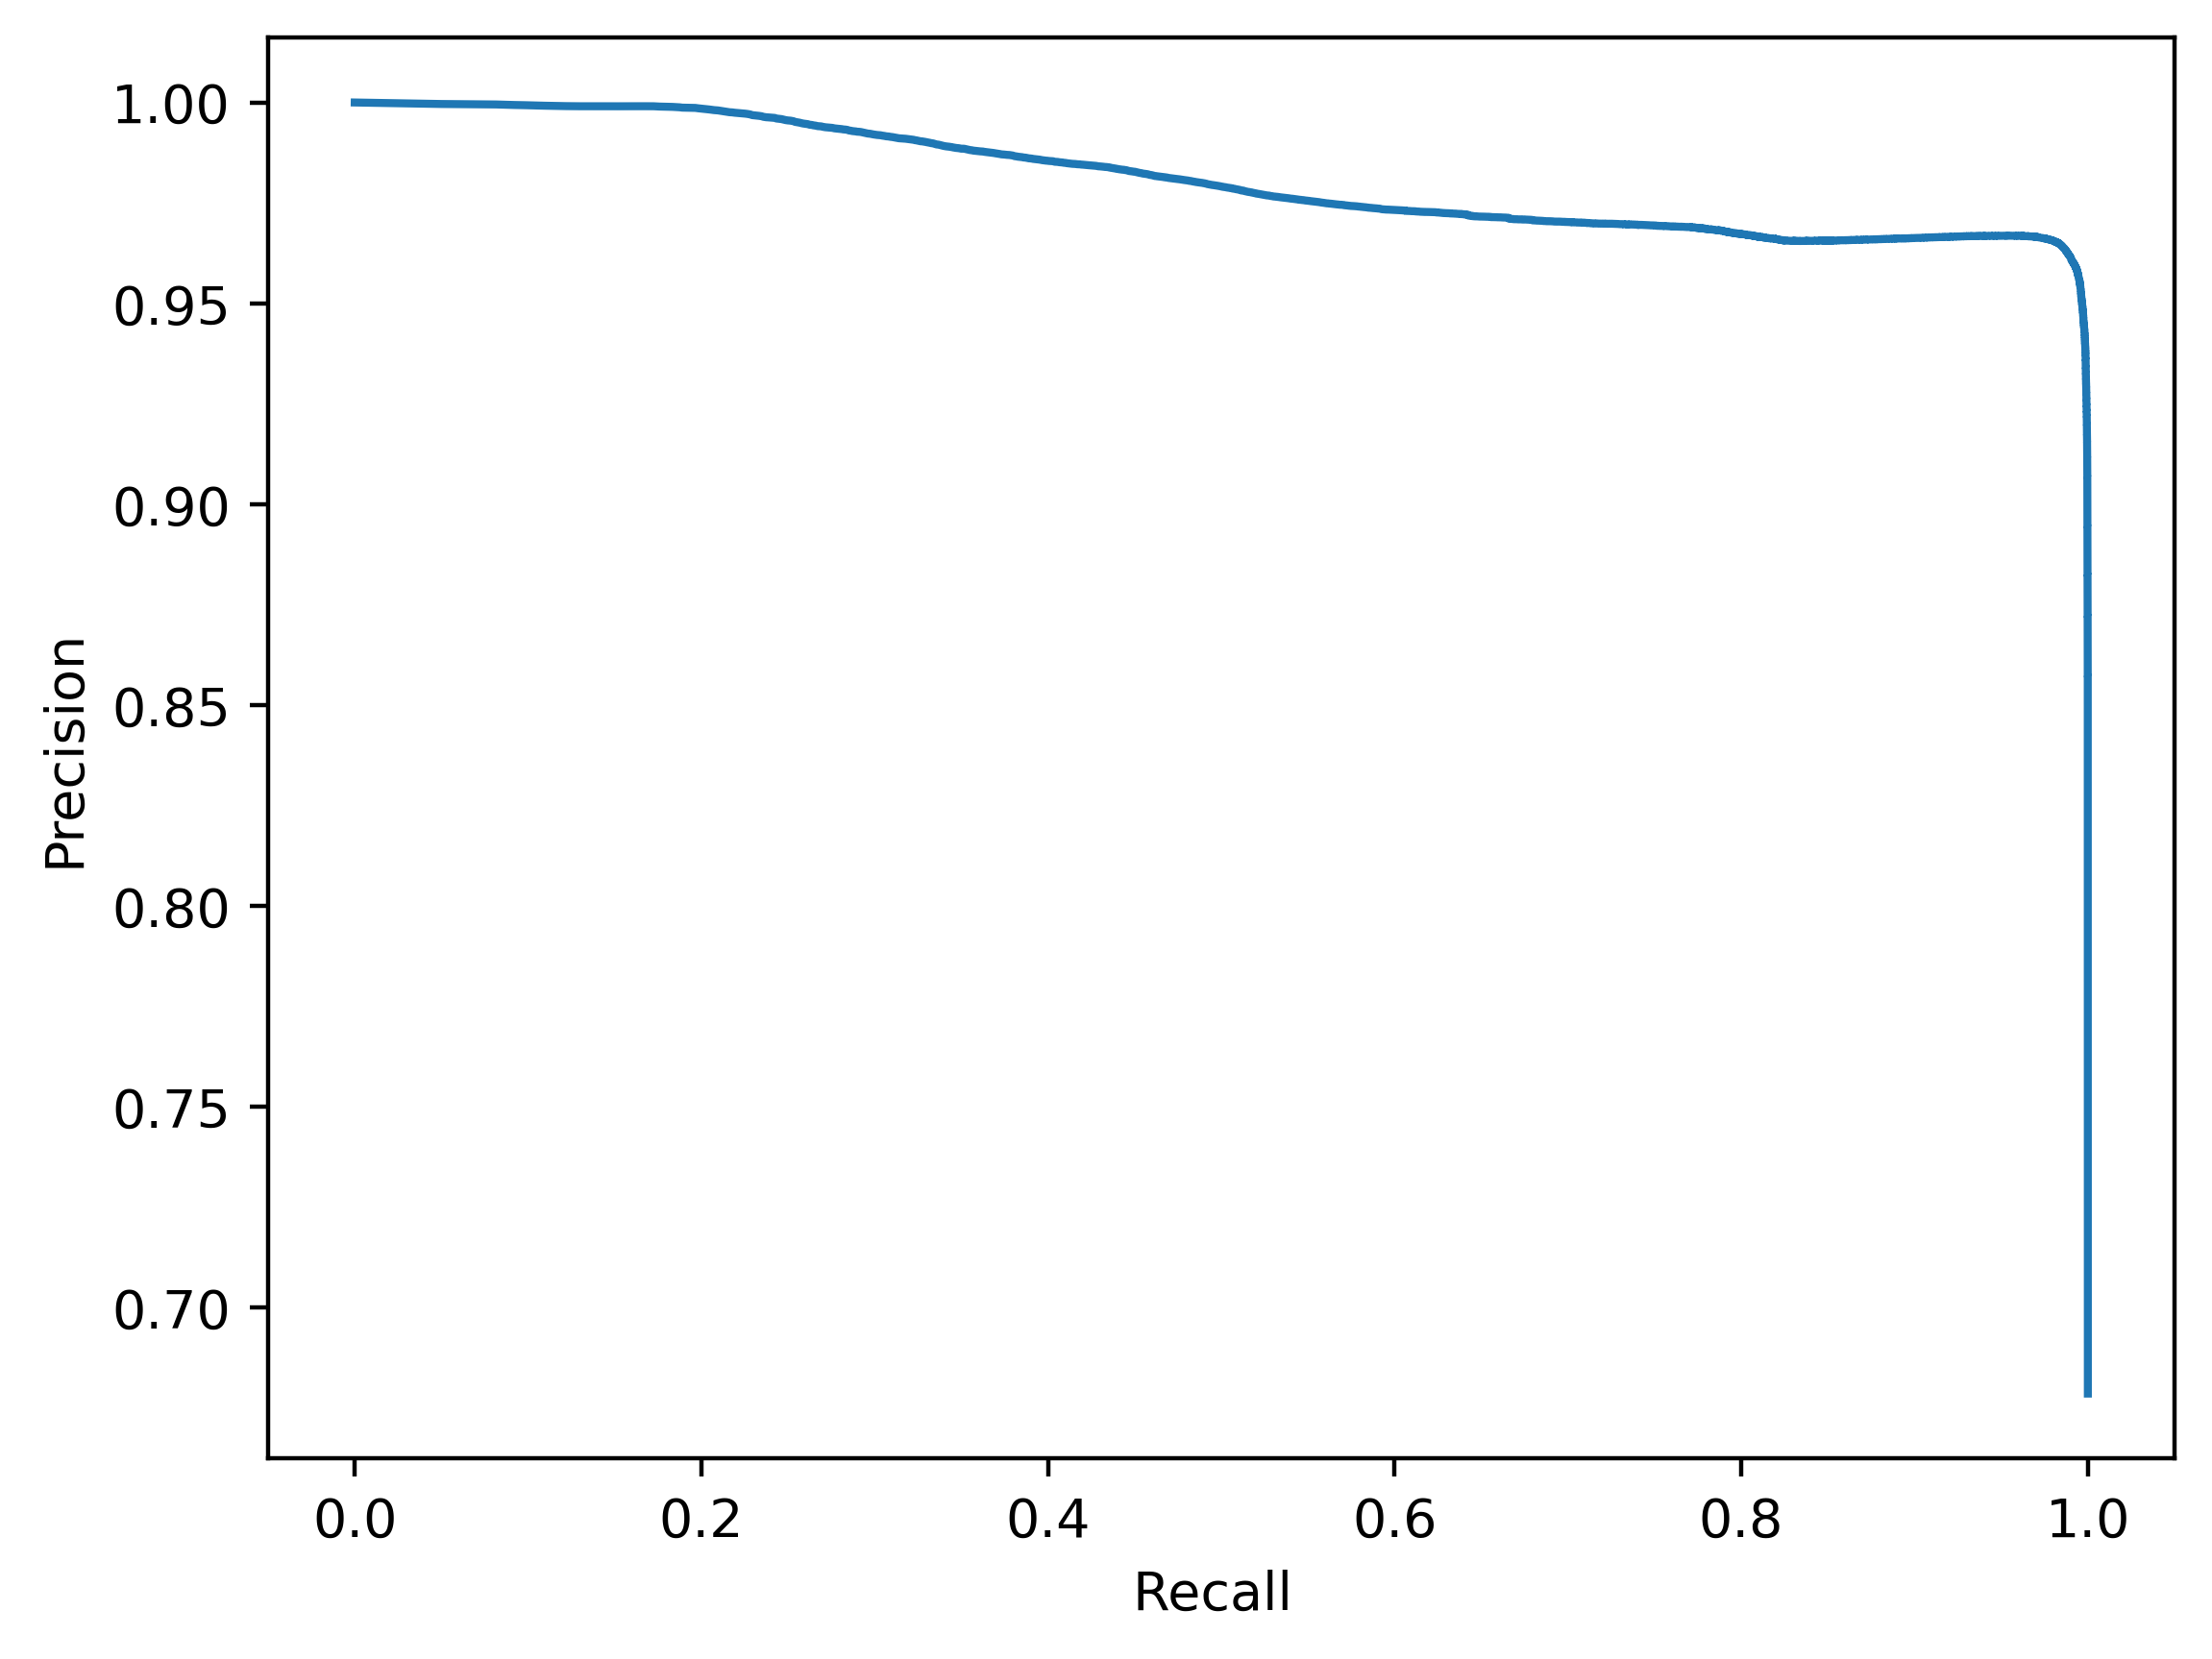

In [561]:
plt.figure(dpi=400)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall ')
plt.show()

In [562]:
print("TRUE NEGATIVE RATE tn/(tn+fp)")
tn/(tn+fp)

TRUE NEGATIVE RATE tn/(tn+fp)


np.float64(0.9357252993090699)

In [563]:
print("FALSE NEGATIVE RATE fn/(fn+tp)")
fn/(fn+tp)

FALSE NEGATIVE RATE fn/(fn+tp)


np.float64(0.1436433784488916)

### Set the target FPR rate 

In [564]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, preds_proba[:,1])

In [565]:
desired_fpr = 0.01

In [566]:
index = np.argmax(fpr > desired_fpr)

In [567]:
threshold_fpr = thresholds[index]

In [568]:
bin_pred = (preds_proba[:, 1] > threshold_fpr).astype(int)

In [569]:
# Find first index where FPR exceeds the desired value
indices = np.where(fpr > desired_fpr)[0]
if len(indices) > 0:
    index = indices[0]
    threshold_fpr = thresholds[index]
else:
    # fallback to max threshold (will predict 0 for everything)
    threshold_fpr = thresholds[-1]

In [570]:
acc=sklearn.metrics.accuracy_score(test_y, bin_pred)
recall=sklearn.metrics.recall_score(test_y, bin_pred)
f1=sklearn.metrics.f1_score(test_y, bin_pred)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(test_y, bin_pred).ravel()
print("usual accuracy and confusion matrix tn, fp, fn, tp")
acc, recall, f1, tn, fp, fn, tp

usual accuracy and confusion matrix tn, fp, fn, tp


(0.5687287032908516,
 0.36924999995801433,
 0.5374951718338231,
 np.int64(2791163),
 np.int64(28080),
 np.int64(3755746),
 np.int64(2198667))

Chosen threshold for closest FPR to 0.001: 0.99999
Actual FPR at chosen threshold: 0.00099
Accuracy: 0.4642982355360183
Recall: 0.21109200856574778
F1 Score: 0.34847318122835
Confusion Matrix: tn, fp, fn, tp = 2816664 2579 4697484 1256929


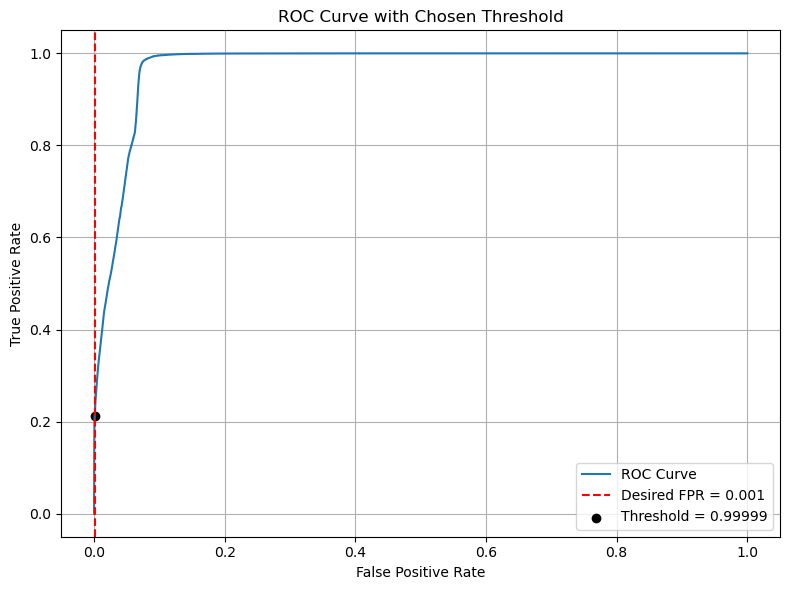

In [571]:
desired_fpr = 0.001  # Target FPR

# 1. Compute ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, preds_proba[:, 1])

# 2. Find threshold closest to desired FPR
index = np.argmin(np.abs(fpr - desired_fpr))
threshold_fpr = thresholds[index]

# 3. Binarize predictions
bin_pred = (preds_proba[:, 1] > threshold_fpr).astype(int)

# 4. Compute metrics
acc = sklearn.metrics.accuracy_score(test_y, bin_pred)
recall = sklearn.metrics.recall_score(test_y, bin_pred)
f1 = sklearn.metrics.f1_score(test_y, bin_pred)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(test_y, bin_pred).ravel()

# 5. Output
print(f"Chosen threshold for closest FPR to {desired_fpr}: {threshold_fpr:.5f}")
print(f"Actual FPR at chosen threshold: {fpr[index]:.5f}")
print("Accuracy:", acc)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix: tn, fp, fn, tp =", tn, fp, fn, tp)

# 6. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.axvline(desired_fpr, color='red', linestyle='--', label=f'Desired FPR = {desired_fpr}')
plt.scatter(fpr[index], tpr[index], color='black', label=f'Threshold = {threshold_fpr:.5f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Chosen Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()